In [5]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests
from matplotlib import pyplot as plt
import os
import torch
import numpy as np
from PIL import Image
%matplotlib inline

In [6]:
query_image = Image.open('./test/test2.jpeg')
# query_image = Image.open('./images/ex1.jpeg')

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

In [7]:
def compute_embedding(model, image):
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    return outputs.last_hidden_state

In [8]:
def load_emd_db(dir_path, model):
    file_names = [f for f in os.listdir(dir_path) if f.endswith('.jpeg') or f.endswith('.jpg')]
    db_emd = []
    # ids = []
    # images = []
    for file_name in file_names:
        img = Image.open(dir_path + file_name)
        if not img is None:
            db_emd.append({'id': file_name,
            'embedding': compute_embedding(model, img),
            'image': img})
    return db_emd

In [9]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.detach().numpy().tolist()
 

In [10]:
def find_matches(model, db_emd, query_image, top_k = 1):
    query_emd = compute_embedding(model, query_image)
    embs = [e['embedding'] for e in db_emd]
    db_ids = [e['id'] for e in db_emd]
    
    scores = [compute_scores(img, query_emd) for img in embs]
    similarity_mapping = dict(zip(db_ids, scores))

    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True))

    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: x, id_entries))

    return ids

In [11]:
def show_images(images, titles,max_image = 4):
    no_images = len(images)
    no_row = int(np.ceil(no_images/max_image))
    print(no_row)
    fig, ax = plt.subplots(no_row, min(no_images, max_image), figsize = (20,5))
    ax = ax.flat
    for i in range(no_images):
        ax[i].imshow(images[i])
        ax[i].set_title(titles[i])
    plt.show()

In [12]:
db_path = './images/'
db_emd = []

In [13]:
if len(db_emd) == 0:
    db_emd = load_emd_db(db_path, model)
closest_images = find_matches(model, db_emd, query_image, 3)

In [15]:
closest_images

['ex1.jpeg', 'ex5.jpg', 'ex3.jpg']

2


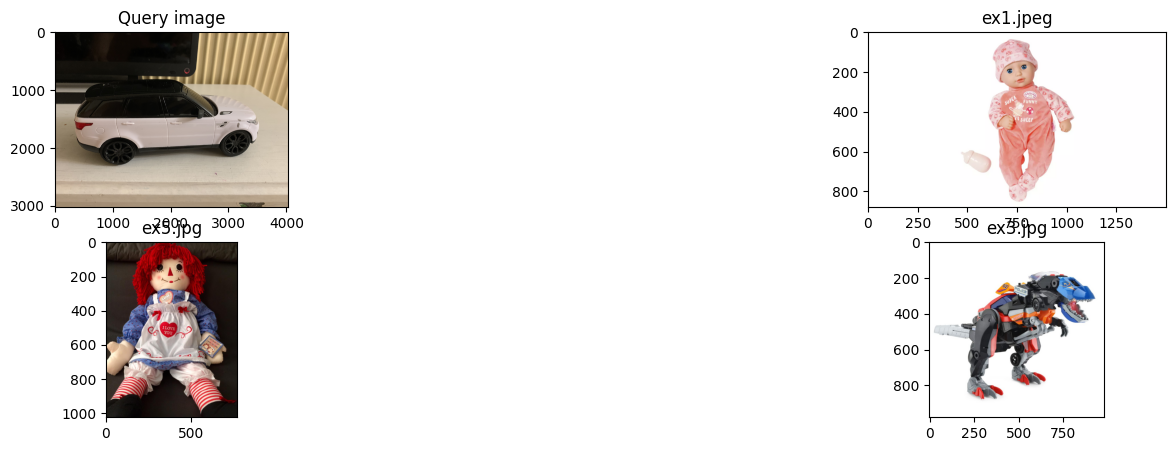

In [14]:
images = [d['image'] for d in db_emd if d['id'] in closest_images]
show_images([query_image] + images, ['Query image'] + closest_images,max_image = 2)